In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip


# Importing Libraries

In [2]:
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

**Extracting training set into a directory named 'training'.**

In [3]:
local_zip = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('training')
zip_ref.close()

**Checking whether the zip files were extracted or not.**

In [4]:
print(len(os.listdir('/kaggle/working/training/train')))

25000


**Make different directories for training and testing (cats and dogs).**

In [5]:
base_dir = '/kaggle/working'
train_dir = os.makedirs(os.path.join(base_dir, 'train'))
validation_dir = os.makedirs(os.path.join(base_dir, 'validation'))

# Directory with our training cat pictures
train_cats_dir = os.makedirs('/kaggle/working/train/cats')

# Directory with our training dog pictures
train_dogs_dir = os.makedirs('/kaggle/working/train/dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.makedirs('/kaggle/working/validation/cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.makedirs('/kaggle/working/validation/dogs')

**Appending files into the training directory and then dividing them into training and validation sets.**

In [6]:
list_images = os.listdir("/kaggle/working/training/train/")
print(len(list_images))
files = []
for file_name in list_images:
    if(os.path.getsize("/kaggle/working/training/train/" + file_name)) > 0:
        files.append(file_name)
    else:
        print(file_name + "has zero length!")
        
files = random.sample(files, len(files))
train_set = files[0 : round(0.8*len(files))]
val_set = files[-(len(files) - len(train_set)) : ]
print("Train-set size:", len(train_set))
print("Validation-set size:", len(val_set))


for file_name in train_set:
    if('cat' in file_name):        
        copyfile("/kaggle/working/training/train/" + file_name, "/kaggle/working/train/cats/" + file_name)
    elif('dog' in file_name):
        copyfile("/kaggle/working/training/train/" + file_name, "/kaggle/working/train/dogs/" + file_name)
        
for file_name in val_set:
    if('cat' in file_name):        
        copyfile("/kaggle/working/training/train/" + file_name, "/kaggle/working/validation/cats/" + file_name)
    elif('dog' in file_name):
        copyfile("/kaggle/working/training/train/" + file_name, "/kaggle/working/validation/dogs/" + file_name)

25000
Train-set size: 20000
Validation-set size: 5000


In [7]:
print("No. of cats in train set ", len(os.listdir("/kaggle/working/train/cats/")))
print("No. of dogs in train set ", len(os.listdir("/kaggle/working/train/dogs/")))
print("No. of cats in validation set ", len(os.listdir("/kaggle/working/validation/cats/")))
print("No. of dogs in validation set ", len(os.listdir("/kaggle/working/validation/dogs/")))

No. of cats in train set  9989
No. of dogs in train set  10011
No. of cats in validation set  2511
No. of dogs in validation set  2489


# Preparing training and validation data

In [8]:
training_dir = "/kaggle/working/train/"
train_datagen = ImageDataGenerator(
                rescale=1./255,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
                  training_dir,
                  batch_size=32,
                  class_mode='binary',
                  target_size=(200, 200))

validation_dir =  "/kaggle/working/validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
                       validation_dir,
                       batch_size=32,
                       class_mode='binary',
                       target_size=(200, 200))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Model

**Here, we have built a Sequential model with 5 convolution layers with the image size 200X200 and a Dense layer with 1024 neurons. We have also specified callbacks based on validation accuracy(patience means process will come to a halt after the no. of epochs for which val_acc doesn't improve).**

In [9]:
# EarlyStopping and Reduce Learning Rate Callbacks
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)
my_callback_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, factor=0.5, min_lr=0.00001, verbose=1)

model = tf.keras.models.Sequential([
    #Conv layer 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 5
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Flatten
    tf.keras.layers.Flatten(),
    #Fully Connected layer
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    #Dropout
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
    
])
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch = len(train_set) // 32,
    epochs = 100,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = len(val_set) // 32,
    callbacks=[my_callback_es, my_callback_rlr])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       7

# Visualizing Accuracy and Loss

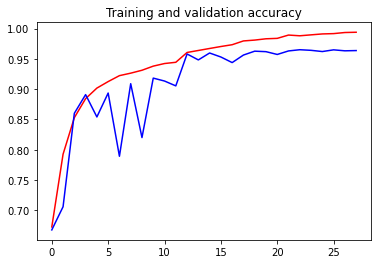

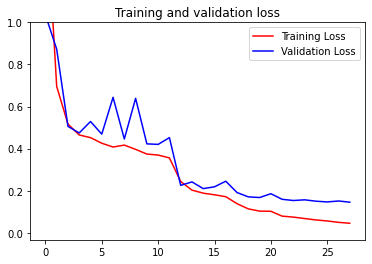

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.ylim(top=1.0)
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

**Saving model for later use.**

In [11]:
model.save_weights('Dense1024_Dropout_model_wieghts.h5')
model.save('Dense1024_Dropout_model_keras.h5')

**Extracting test file into 'testing' directory.**

In [12]:
local_zip = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('testing')
zip_ref.close()

In [13]:
test_images = os.listdir('/kaggle/working/testing/test')
print(len(test_images))

print(test_images[0:5])

ID = [int(test_img[:-4]) for test_img in test_images]
print(ID[0:5])

12500
['28.jpg', '2730.jpg', '3567.jpg', '4145.jpg', '1148.jpg']
[28, 2730, 3567, 4145, 1148]


# Preparing Test data

In [14]:
test_dir = "/kaggle/working/testing/"
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size=(200, 200),
                 batch_size=32,
                 class_mode='binary',
                 shuffle=False)

test_generator.reset()
predictions = model.predict_generator(test_generator, verbose=1)

Found 12500 images belonging to 1 classes.
391/391 [==============================] - 42s 107ms/step


**Flatten the prections for submission.**

In [15]:
predictions = predictions.flatten()

In [16]:
submission = pd.DataFrame({"id": ID, "label": predictions})
submission.to_csv("dogs_cats.csv", index = False)
submission.head()

,id,label
0,28,9.999907e-01
1,2730,1.282876e-07
2,3567,7.193036e-02
3,4145,1.000000e+00
4,1148,9.957204e-01
